In [ ]:
import sys

sys.path.insert(0, "..")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Our modules
from src.agents.ppo_agent import PPOAgent
from src.mdp import RewardFunction, State
from src.agents.callbacks.learning_curve_callback import LearningCurveCallback
from src.agents.metrics import TrainingMetrics, EvaluationMetrics
from src.seeds import generate_seeds

# Plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

# Initialize plot classes
training_plots = TrainingMetrics()
evaluation_plots = EvaluationMetrics()

## 1. Experiment Configuration

We define the global simulation parameters and initialize the random number generators for the agent.

**Parameters:**
- `EPISODE_LENGTH`: Duration of a single simulation episode (Days).
- `TRAINING_SEED`: Fixed seed for reproducible training loops.
- `EVAL_SEED`: Single seed for single-instance validation.
- `EVAL_SEEDS`: A list of 100 distinct seeds for robust statistical evaluation.

**Key consideration:**
- **Generalization:** We use separate seeds for training vs. evaluation to ensure the agent learns general strategies rather than overfitting to specific random sequences.

In [ ]:
# Configuration
EPISODE_LENGTH = 100  # days

TRAINING_SEED = generate_seeds(1, start_index=20)[0]
EVAL_SEED = generate_seeds(1, start_index=21)[0]
EVAL_SEEDS = generate_seeds(100, start_index=100)

print("🎲 PPO Training Seeds (DETERMINISTIC):")
print(f"   Training: {TRAINING_SEED}")
print(f"   Validation: {EVAL_SEED}")
print(f"   Final evaluation: {len(EVAL_SEEDS)} seeds starting at {EVAL_SEEDS[0]}")

🎲 PPO Training Seeds (DETERMINISTIC):
   Training: 6173
   Validation: 29
   Final evaluation: 100 seeds starting at 2216


# 2. Environment Setup

Factory function to instantiate the RL environment and apply a normalization wrapper to prepare the data for the neural network.


In [ ]:
from src.agents.normalization_wrapper import InventoryNormalizationWrapper
from src.environment.gym_env import InventoryEnvironment

def make_env(
    episode_length: int = EPISODE_LENGTH,
    random_seed: int = TRAINING_SEED,
) -> InventoryEnvironment:
    return InventoryEnvironment(
        k=25,
        Q_max=40,
        episode_length=episode_length,
        random_seed=random_seed,
    )


env = make_env(random_seed=TRAINING_SEED)

print(env)

Inventory Management Gym Environment (k=32, Q_max=42, episode_length=365)


## 3. Create and Train DQN Agent

**Hyperparameter choices:**
- `learning_rate`: [1e-5, 1e-3] - use 1e-4 as conservative start
- `gamma`: [0.95, 0.999] 
- `buffer_size`: Large enough for decorrelation
- `exploration_fraction`: 30% of training for ε-decay

In [ ]:
# Create PPO Agent with deterministic seed
agent = PPOAgent(
    env=env,
    learning_rate=3e-4,
    gamma=0.99,  # High gamma for farsighted planning
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    clip_range=0.2,
    ent_coef=0.01,
    gae_lambda=0.95,
    tensorboard_log=None,  # Disable TensorBoard
    policy_kwargs=dict(net_arch=[256, 256]),
    seed=TRAINING_SEED,
    verbose=0,
)

print(f"✅ PPO Agent created with seed {TRAINING_SEED}")

✅ PPO Agent created with seed 6173


## 4. Training

Train the PPO agent with periodic evaluation.

**Monitor with TensorBoard:**
```bash
tensorboard --logdir=./logs
```

In [ ]:
# Training parameters
TOTAL_TIMESTEPS = 1_000_000 * 2

print(f"🚀 Starting training for {TOTAL_TIMESTEPS:,} timesteps...")
print(f"   ≈ {TOTAL_TIMESTEPS // EPISODE_LENGTH:,} episodes\n")

learning_curve_callback = LearningCurveCallback()

# Train the agent with callback
agent.train(
    total_timesteps=TOTAL_TIMESTEPS,
    progress_bar=True,
    callbacks=learning_curve_callback,
)

print(f"\n✅ Training complete!")
print(f"   Episodes recorded: {len(learning_curve_callback.episode_rewards)}")

Output()

🚀 Starting training for 1,000,000 timesteps...
   ≈ 2,739 episodes




✅ Training complete!
   Episodes recorded: 2743


## 4. Save the Trained Model

In [6]:
agent.save()

PPO weights saved to models


---
## Phase 1: Training Analysis

### 1. Learning Curve (Training Stability)
Average Reward per Episode vs. Timesteps.


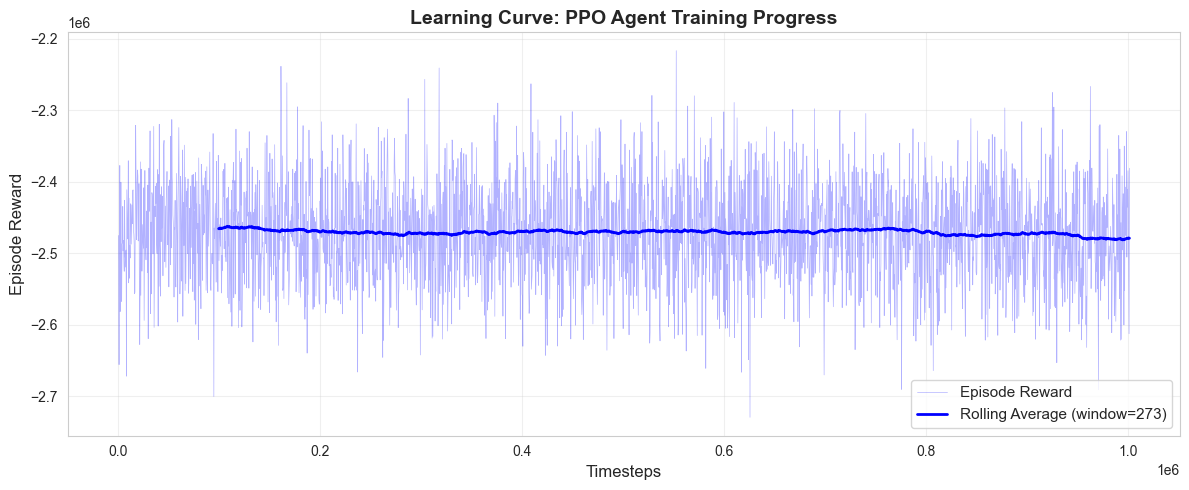

📊 Training Statistics:
  Total Episodes: 2743
  Total Timesteps: 1001195
  Episode Length: 365.00 timesteps

  -- Performance (Last 273 episodes) --
  Mean Reward:   -2478888.25 ± 71559.04
  Min Reward:    -2690985.00
  Max Reward:    -2266521.00

  -- Specifics --
  Best Ever Reward: -2216484.00
  Last Ep Reward:   -2380972.00

 -- Daily Rewards --
  Mean Reward per Day: -6769.53 ± 191.02
  Final Mean Reward per Day (last 273 eps): -6791.47 ± 196.05


In [7]:
window = int(0.1 * (TOTAL_TIMESTEPS // EPISODE_LENGTH))

# Learning Curve: Use data from callback
training_plots.plot_learning_curve(
    episode_timesteps=learning_curve_callback.episode_timesteps,
    episode_rewards=learning_curve_callback.episode_rewards,
    window=window,
    title="Learning Curve: PPO Agent Training Progress",
)

---
# Phase 2: Evaluation & Testing
Run N=100 independent test episodes with deterministic policy.


In [8]:
# Run N=100 test episodes with deterministic policy
# Using pre-generated EVAL_SEEDS for reproducibility
N_TEST_EPISODES = len(EVAL_SEEDS)

reward_fn = RewardFunction()
# Storage for test results
test_episodes_ppo = []

print(f"🧪 Running {N_TEST_EPISODES} test episodes with deterministic seeds...")

for ep, seed in enumerate(EVAL_SEEDS):
    # PPO Agent Episode
    ppo_env = make_env(random_seed=seed)

    obs, _ = ppo_env.reset()

    ppo_data = {
        "net_inv_0": [],
        "net_inv_1": [],
        "q0": [],
        "q1": [],
        "demand_0": [],
        "demand_1": [],  # Daily demand per product
        "ordering_cost": [],
        "holding_cost": [],
        "shortage_cost": [],
        "total_daily_cost": [],
    }

    done = False
    while not done:
        action = agent.select_action(obs, deterministic=True)
        action_obj = ppo_env.action_space_config.get_action(action)
        obs, reward, terminated, truncated, info = ppo_env.step(action)

        # Log Inventory & Actions
        ppo_data["net_inv_0"].append(info["net_inventory"][0])
        ppo_data["net_inv_1"].append(info["net_inventory"][1])
        ppo_data["q0"].append(action_obj.order_quantities[0])
        ppo_data["q1"].append(action_obj.order_quantities[1])

        # Log Daily Demand per product
        ppo_data["demand_0"].append(info["total_demand"][0])
        ppo_data["demand_1"].append(info["total_demand"][1])

        # Compute Daily Cost Components using RewardFunction
        state = State(
            net_inventory=tuple(info["net_inventory"]),
            outstanding_orders=tuple(info["outstanding"]),
        )
        costs = reward_fn.calculate_costs(state, action_obj)

        # Append to lists
        ppo_data["ordering_cost"].append(costs.ordering_cost)
        ppo_data["holding_cost"].append(costs.holding_cost)
        ppo_data["shortage_cost"].append(costs.shortage_cost)
        ppo_data["total_daily_cost"].append(costs.total_cost)

        done = terminated or truncated

    test_episodes_ppo.append(ppo_data)

print(f"✅ Collected {N_TEST_EPISODES} test episodes for PPO")
print(f"   Seeds used: {EVAL_SEEDS[0]} to {EVAL_SEEDS[-1]}")
print(f"   All seeds are deterministic and saved for reproducibility")

🧪 Running 100 test episodes with deterministic seeds...
✅ Collected 100 test episodes for PPO
   Seeds used: 2216 to 2415
   All seeds are deterministic and saved for reproducibility


In [ ]:
all_daily_costs = np.concatenate([ep["total_daily_cost"] for ep in test_episodes_dqn])
episode_totals = np.array([sum(ep["total_daily_cost"]) for ep in test_episodes_dqn])

# Calcolo Demand (Somme totali)
d0_total = sum(sum(ep["demand_0"]) for ep in test_episodes_dqn)
d1_total = sum(sum(ep["demand_1"]) for ep in test_episodes_dqn)
total_customers = d0_total + d1_total
num_episodes = len(test_episodes_dqn)

# --- 2. Statistics Calculation ---
# Dizionario compatto per i risultati
stats = {
    "daily_mean": np.mean(all_daily_costs),
    "daily_std": np.std(all_daily_costs, ddof=1),
    "total_mean": np.mean(episode_totals),
    "total_std": np.std(episode_totals, ddof=1),
}

# Calcolo Confidence Intervals (95%)
# Nota: Per daily si usa N=giorni totali, per yearly si usa N=episodi
stats["daily_ci"] = 1.96 * stats["daily_std"] / np.sqrt(all_daily_costs.size)
stats["total_ci"] = 1.96 * stats["total_std"] / np.sqrt(num_episodes)

# --- 3. Optimized Printing ---
def print_header(title):
    print(f"\n{'='*60}")
    print(f"{title:^60}")  # Centra il testo
    print(f"{'='*60}")

# Stampa Daily
print_header("RESULTS - DAILY COST METRICS")
print(f"  Mean Cost      : ${stats['daily_mean']:>10.2f} / day")
print(f"  Std Deviation  : ${stats['daily_std']:>10.2f}")
print(f"  95% Conf. Int. : ±${stats['daily_ci']:>9.2f}")

# Stampa Yearly
print_header("RESULTS - YEARLY (EPISODE) METRICS")
print(f"  Mean Cost      : ${stats['total_mean']:>10.2f} / year")
print(f"  Std Deviation  : ${stats['total_std']:>10.2f}")
print(f"  95% Conf. Int. : ±${stats['total_ci']:>9.2f}")

# Stampa Demand
print_header("DEMAND STATISTICS")
print(f"  Total Customers  : {total_customers:,.0f}")
print(f"  Avg Cust/Episode : {total_customers/num_episodes:.1f}")
print(f"  {'-'*56}")
print(f"  Product 0 (Tot)  : {d0_total:,.0f} (Avg: {d0_total/num_episodes:.1f})")
print(f"  Product 1 (Tot)  : {d1_total:,.0f} (Avg: {d1_total/num_episodes:.1f})")
print(f"{'='*60}\n")

### 1. Warm-up Period Analysis (Welch's Graphical Procedure)
Since the simulation starts with initial inventory conditions, the early data may be biased (transient phase). 
We use Welch's procedure to identify when steady-state begins.

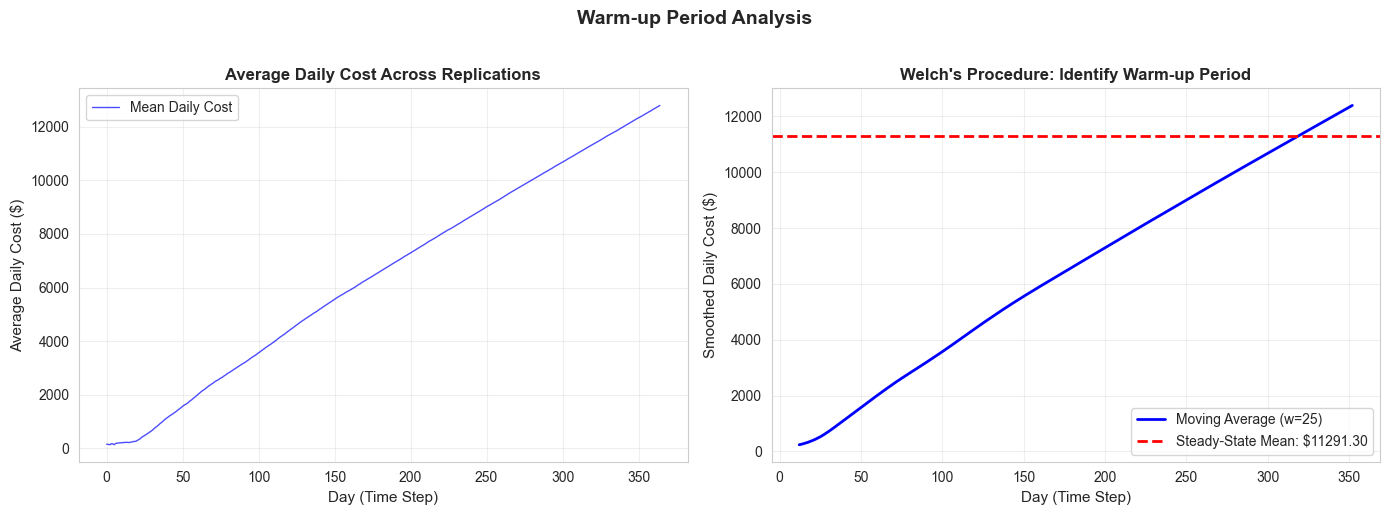

📊 Welch's Procedure Summary:
   Total replications: 100
   Episode length:     365 days
   Moving average window:    25

📈 Results & Convergence:
   Steady-State Mean: $11291.30
   Stability (Std Dev):    647.55 (Lower is better/flatter)

⚠️  Visually inspect the right plot to identify where the curve flattens.


In [9]:
# Welch's Graphical Procedure for Warm-up Detection
n_days, n_reps = evaluation_plots.plot_welch_procedure(
    test_episodes=test_episodes_ppo,
    window_size=25,
    title="Warm-up Period Analysis",
)

In [10]:
# Set warm-up length based on visual inspection of Welch's plot
# Adjust this value based on where the curve flattens
WARMUP_LENGTH = 75  # days to discard from beginning of each episode

print(f"✅ Warm-up length set to {WARMUP_LENGTH} days")
print(f"   Steady-state analysis will use days {WARMUP_LENGTH+1} to {n_days}")
print(f"   Effective data per episode: {n_days - WARMUP_LENGTH} days")

✅ Warm-up length set to 75 days
   Steady-state analysis will use days 76 to 365
   Effective data per episode: 290 days


### 2. Cost Component Breakdown (Economic Analysis)
Grouped bar chart decomposed into Ordering, Holding, and Shortage costs.

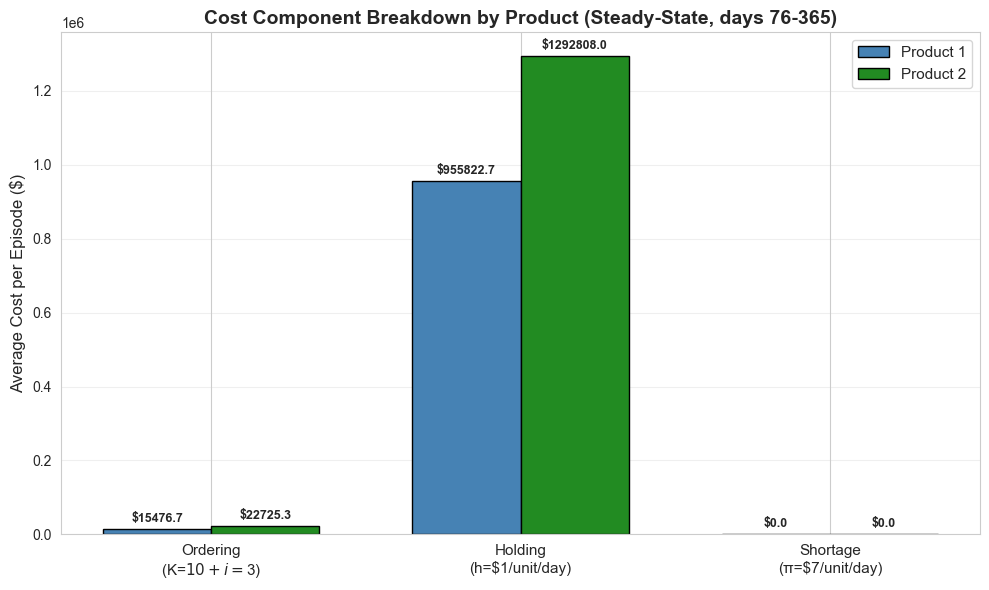

📊 Steady-State Average Cost per Episode (days 76-365):

  Product 1: $971299.41
    Ordering: $15476.74 (1.6%)
    Holding:  $955822.67 (98.4%)
    Shortage: $0.00 (0.0%)

  Product 2: $1315533.30
    Ordering: $22725.30 (1.7%)
    Holding:  $1292808.00 (98.3%)
    Shortage: $0.00 (0.0%)

------------------------------------------------------------

  TOTAL: $2286832.71


In [11]:
# Cost Component Breakdown by Product
evaluation_plots.plot_cost_breakdown_by_product(
    test_episodes=test_episodes_ppo,
    warmup_length=WARMUP_LENGTH,
    n_days=n_days,
    title="Cost Component Breakdown by Product",
)

### 3. Operational Time Series (Behavioral Analysis)
Snapshot of 100 days showing Net Inventory and Replenishment Actions for Product 1 and Product 2.


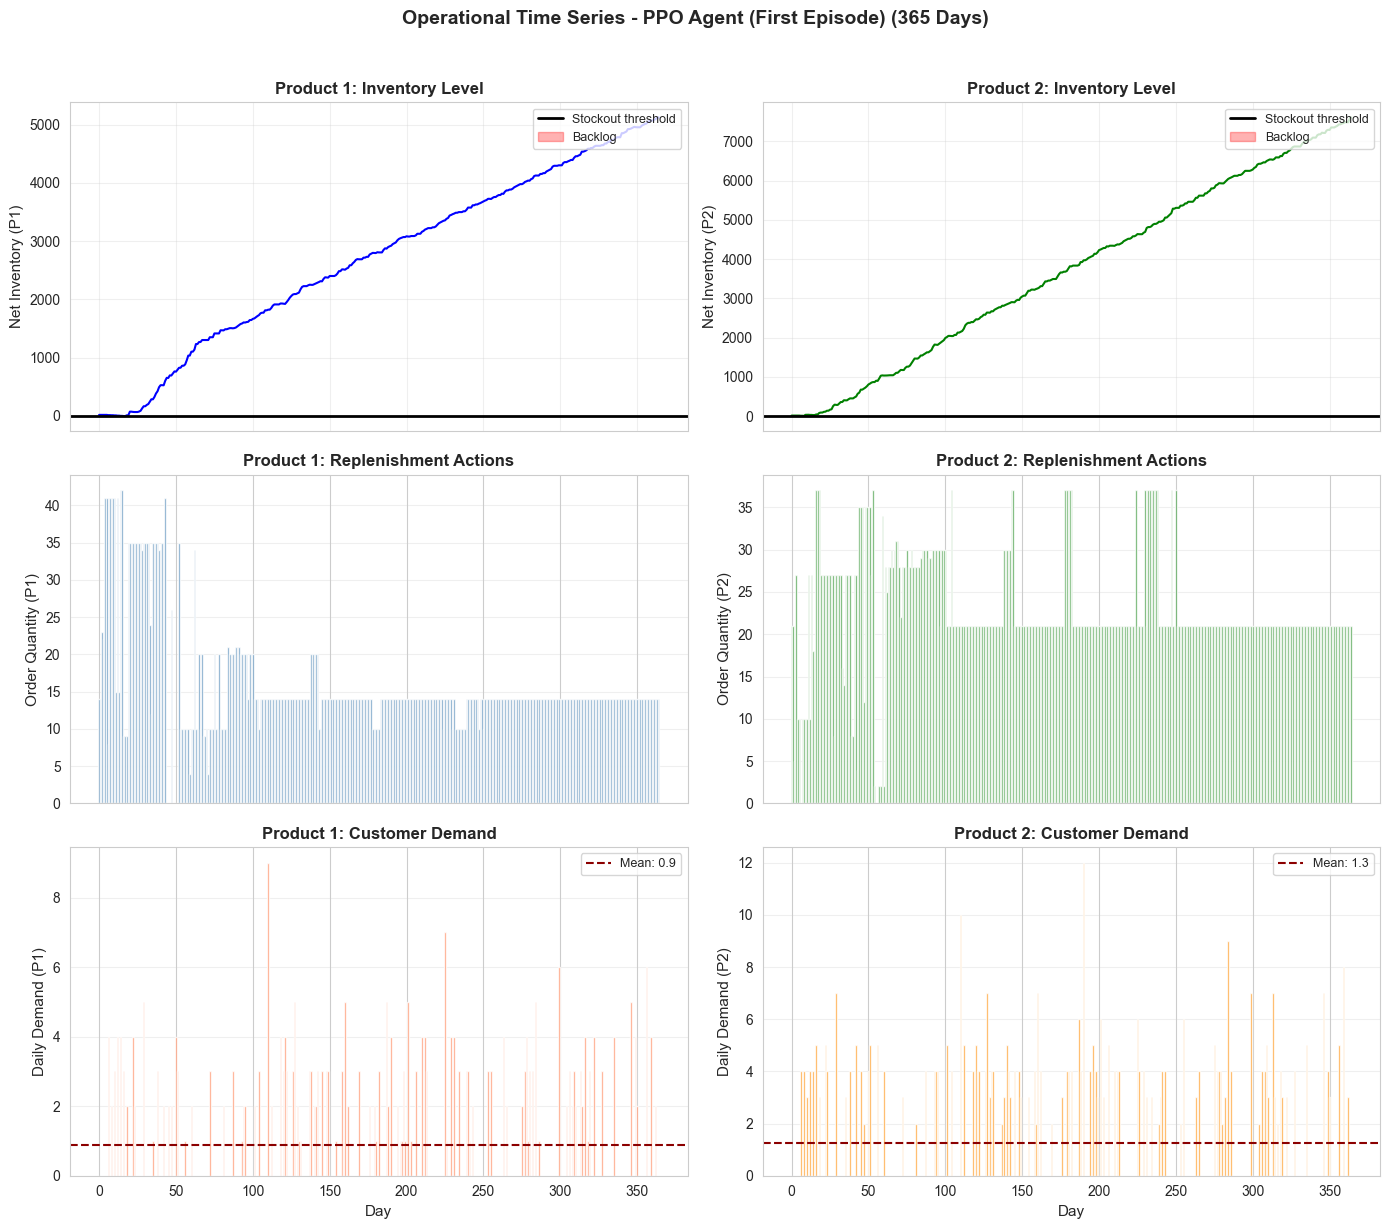

In [12]:
# Select representative episode (closest to mean total cost)
# episode_avg_costs = [np.mean(ep['total_daily_cost']) for ep in test_episodes_ppo]
# global_mean_cost = np.mean(episode_avg_costs)
# representative_idx = np.argmin(np.abs(np.array(episode_avg_costs) - global_mean_cost))

# print(f"📊 Representative episode: {representative_idx} (avg cost: {episode_avg_costs[representative_idx]:.2f}, global mean: {global_mean_cost:.2f})")

# Operational Time Series - Use the first episode
evaluation_plots.plot_operational_timeseries(
    episode_data=test_episodes_ppo[0],
    title="Operational Time Series - PPO Agent (First Episode)",
)

### 4. Inventory Distribution Histogram (Risk Profile)
Distribution of Net Inventory levels over all test episodes. Red = Backlog (I < 0), Green = On-Hand (I > 0).


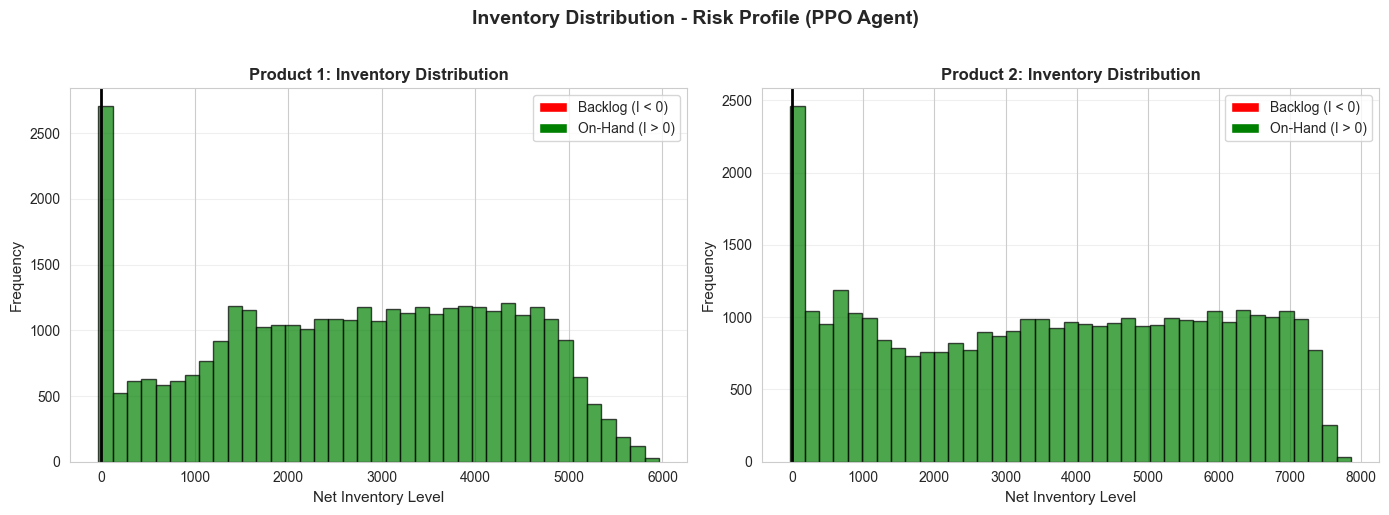

⚙️Service Level (% days without stockout):
  Product 1: 98.5%
  Product 2: 99.6%


In [13]:
# Inventory Distribution Histogram
evaluation_plots.plot_inventory_histogram(
    test_episodes=test_episodes_ppo,
    title="Inventory Distribution - Risk Profile (PPO Agent)",
)